In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(edgeitems=20, precision=3, linewidth=160)
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline

import bayesianchangepoint as bcp


# the switching binomial generative model


In [2]:
import glob
import pickle
for fname in glob.glob('data/pari*pkl'):
    l = fname.split('/')[1].split('.')[0].split('_')
    if l[1]=='AM' :
        a = 'data/pari_AM_%s.pkl'%(l[2]+'_'+l[3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp = b

N_blocks, N_trials = 3, 200
Jeffreys = True
p0, r0 = .5, 2. - Jeffreys
p = exp['p']
tau = 40
h = 1./tau

In [3]:
max_run_length = 150
tau = np.arange(1, 1601, 1)
hs = 1/tau
N_scan = len(hs)

modes = ['mean']#, 'leaky']
mode = 'mean'

## performing inference: application to synthetic data

## testing different hazard rates: qualitative study

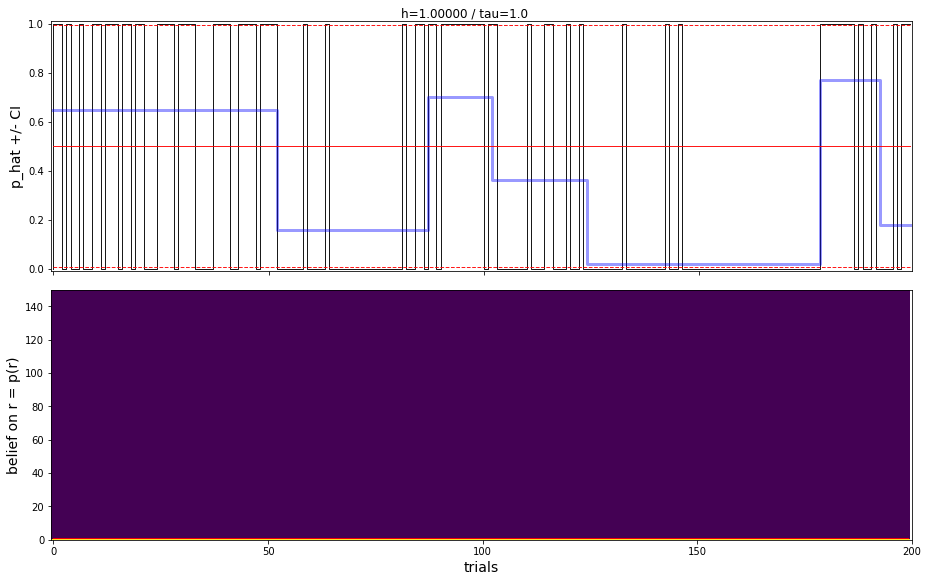

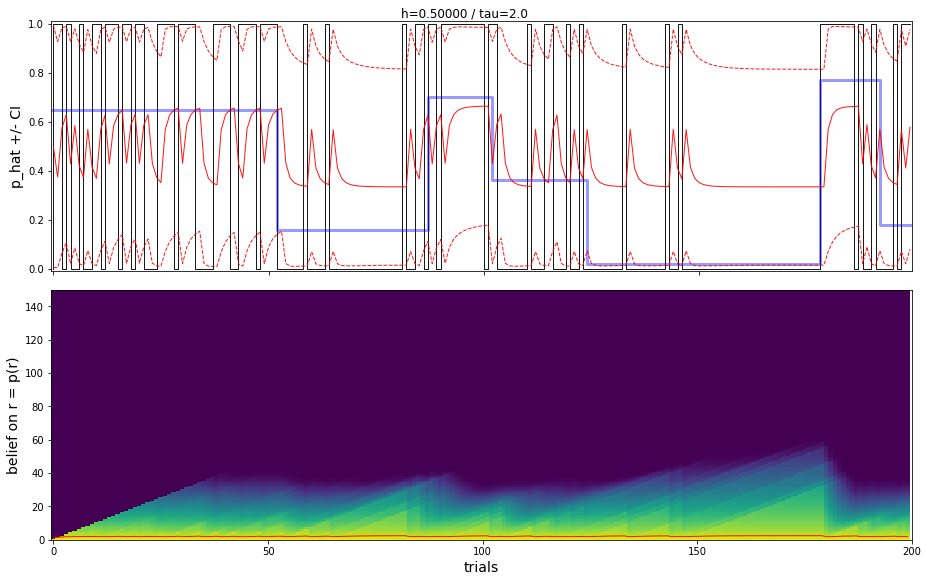

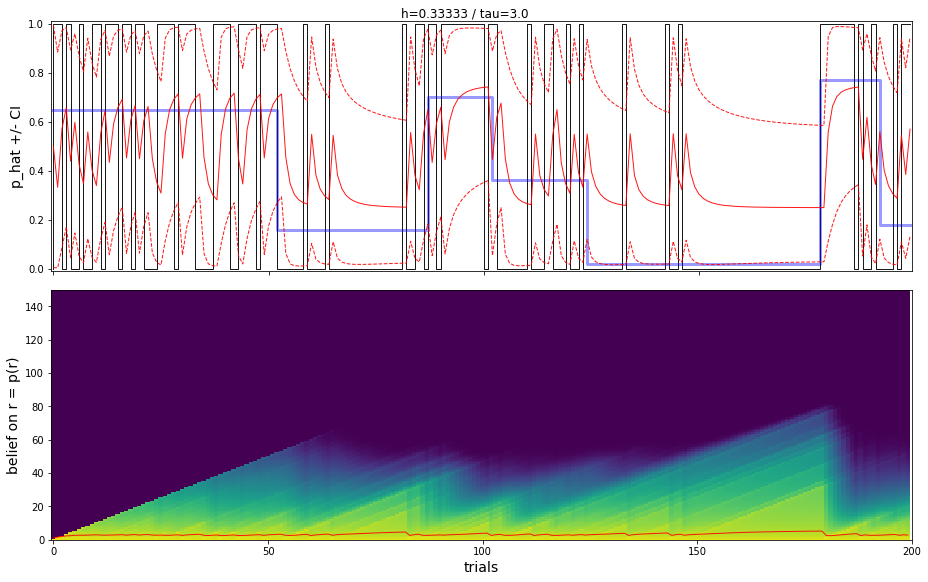

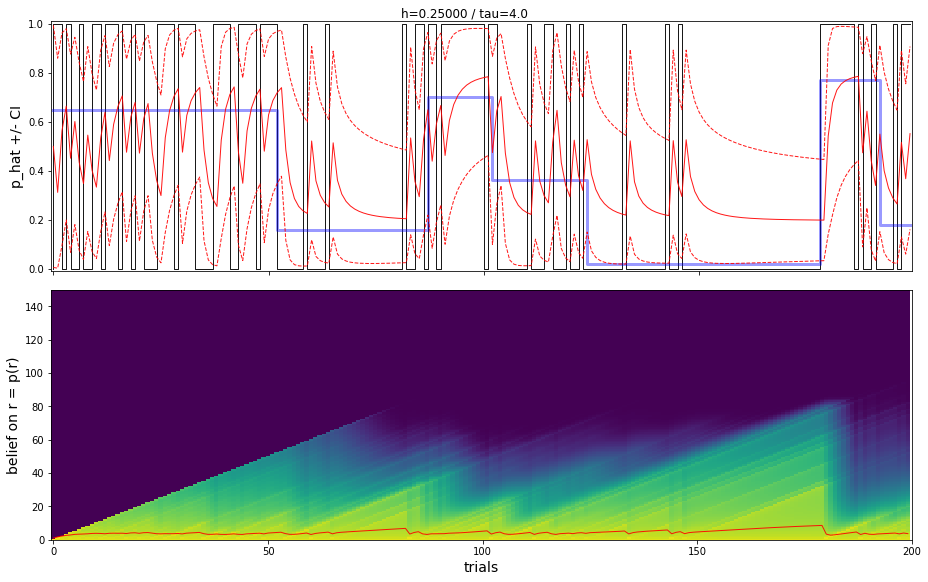

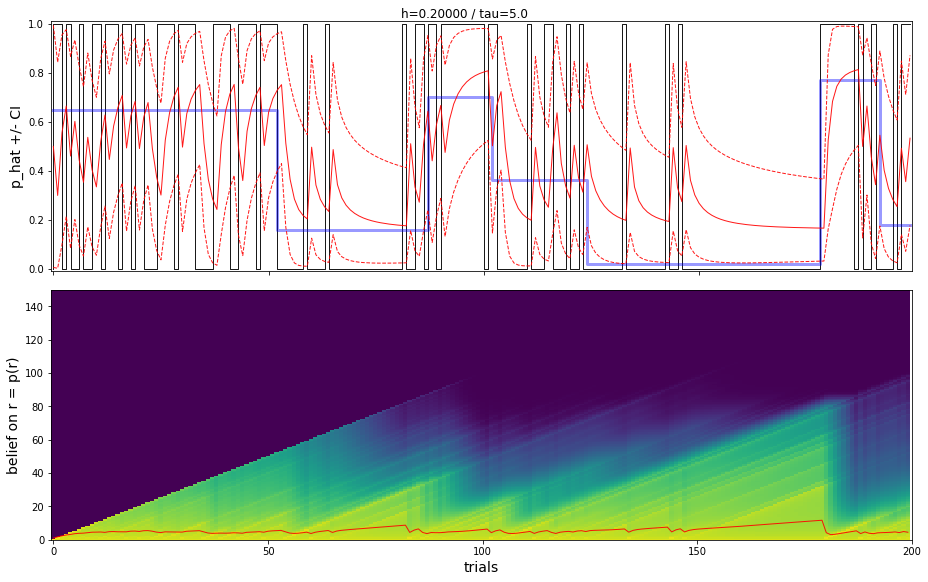

In [4]:
i_block = 0
for h_ in hs[:5]:
    o = p[:, i_block, 0]
    p_bar, r, beliefs = bcp.inference(o, h=h_, p0=p0, r0=r0)
    fig, axs = bcp.plot_inference(o, p[:, i_block, 1], p_bar, r, beliefs, mode=mode, max_run_length=max_run_length)
    fig.suptitle('h=%.5f' % h_ + ' / tau=%.1f' % (1/h_), y=1)
    plt.show()

## evaluating the best hazard rate using a likelihood score between the predicted bias and the true observations

In [5]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

In [6]:
def KL_distance(p_hat_ref, p_hat_obs):
    distance =  - p_hat_obs * np.log2(p_hat_ref) - (1-p_hat_obs) * np.log2(1-p_hat_ref)
    distance +=   p_hat_obs * np.log2(p_hat_obs) + (1-p_hat_obs) * np.log2(1-p_hat_obs)
    return distance

Evaluating the average gain of the bet by actually drawing a TD from $\hat{x_1}$

In [7]:
def pred_score(x_0_true, p_hat_agent):
    score = x_0_true * np.log2(p_hat_agent) + (1-x_0_true) * np.log2(1-p_hat_agent)
    return score

In [8]:
coco = np.zeros((len(modes), N_scan, N_blocks))
KL = np.zeros((len(modes), N_scan, N_blocks))
score = np.zeros((len(modes), N_scan, N_blocks))

for i_block in range(N_blocks):
    o = p[:, i_block, 0] # observations
    p_true = p[:, i_block, 1]
    
    for i_scan, h_ in enumerate(hs):
        p_bar, r, beliefs = bcp.inference(o, h=h_, p0=p0, r0=r0)
        for i_mode, mode_ in enumerate(modes):
            if mode_ in ['fixed', 'leaky']: 
                p_hat_agent, r_hat_agent = bcp.readout(p_bar, r, beliefs, mode=mode_, fixed_window_size=int(1/h_))
            else:
                p_hat_agent, r_hat_agent = bcp.readout(p_bar, r, beliefs, mode=mode_, p0=p0)
            
            coco[i_mode, i_scan, i_block] = r_(p_hat_agent, p_true)
            KL[i_mode, i_scan, i_block] = np.mean(KL_distance(p_true, p_hat_agent))
            score[i_mode, i_scan, i_block] = np.mean(pred_score(o, p_hat_agent))

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [9]:
coco_p = np.zeros((len(modes), N_scan, N_blocks))
KL_p = np.zeros((len(modes), N_scan, N_blocks))
score_p = np.zeros((len(modes), N_scan, N_blocks))

for i_block in range(N_blocks):
    o = p[:, i_block, 0] # observations
    p_true = p[:, i_block, 1]
    
    for i_scan, h_ in enumerate(hs):
        
        for i_mode, mode_ in enumerate(modes):
            
            p_hat_agent = np.zeros(200)

            liste = [0, 50, 100, 150, 200]
            for a in range(len(liste)-1) :
                p_bar, r_bar, beliefs = bcp.inference(o[liste[a]:liste[a+1]], h=h_, p0=.5, r0=1.)
                if mode_ in ['fixed', 'leaky']: 
                    p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=mode_, fixed_window_size=int(1/h_))
                else:
                    p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=mode_, p0=p0)
                
                p_hat_agent[liste[a]:liste[a+1]] = p_hat_p
            
            
            coco_p[i_mode, i_scan, i_block] = r_(p_hat_agent, p_true)
            KL_p[i_mode, i_scan, i_block] = np.mean(KL_distance(p_true, p_hat_agent))
            score_p[i_mode, i_scan, i_block] = np.mean(pred_score(o, p_hat_agent))

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


### evaluating the best hazard rate using the Mean score

In [10]:
c=['olive', 'peru', 'brown']

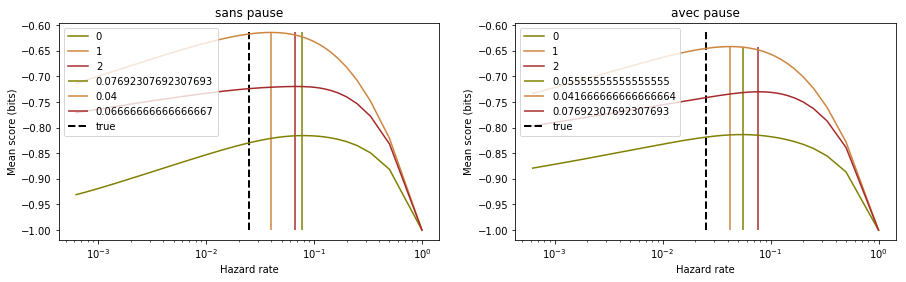

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for i_block in range(N_blocks):
    for i_mode, mode in enumerate(modes):
        
        ax[0].plot(hs, score[i_mode, :, i_block], label=i_block, c=c[i_block])
        ax[0].vlines(hs[np.argmax(score[i_mode, :, i_block])], ymin=np.nanmin(np.nanmean(score, axis=(0))),
                     ymax=np.nanmax(np.nanmean(score, axis=(0))),
                     color=c[i_block], label=hs[np.argmax(score[i_mode, :, i_block])])
        
        ax[1].plot(hs, score_p[i_mode, :, i_block], label=i_block, c=c[i_block])
        ax[1].vlines(hs[np.argmax(score_p[i_mode, :, i_block])], ymin=np.nanmin(np.nanmean(score_p, axis=(0))),
                     ymax=np.nanmax(np.nanmean(score_p, axis=(0))),
                     color=c[i_block], label=hs[np.argmax(score_p[i_mode, :, i_block])])

for a in range(2) :
    ax[a].vlines(h, ymin=np.nanmin(np.nanmean(score, axis=(0))), ymax=np.nanmax(np.nanmean(score, axis=(0))), 
              linestyle='--', lw=2, label='true')

    ax[a].set_xscale("log")
    ax[a].set_xlabel('Hazard rate')
    ax[a].set_ylabel('Mean score (bits)')
    ax[a].legend(loc=2)
    
ax[0].set_title('sans pause')
ax[1].set_title('avec pause');

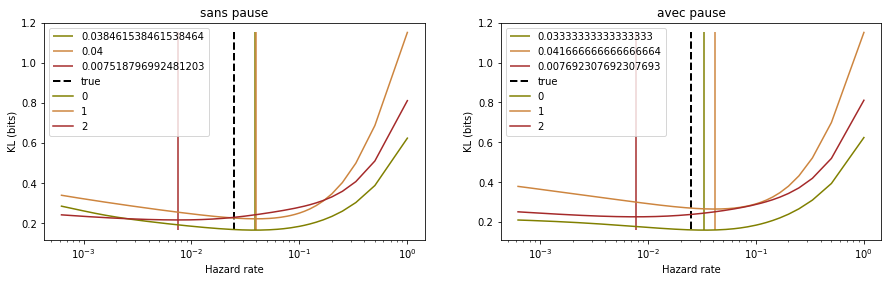

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for i_block in range(N_blocks):
    for i_mode, mode in enumerate(modes):
        ax[0].errorbar(hs, KL[i_mode, :, i_block], label=i_block, c=c[i_block])
        ax[0].vlines(hs[np.argmin(KL[i_mode, :, i_block])], ymin=np.nanmin(np.nanmean(KL, axis=(0))),
                     ymax=np.nanmax(np.nanmean(KL, axis=(0))), 
                     color=c[i_block], label=hs[np.argmin(KL[i_mode, :, i_block])])
        
        ax[1].errorbar(hs, KL_p[i_mode, :, i_block], label=i_block, c=c[i_block])
        ax[1].vlines(hs[np.argmin(KL_p[i_mode, :, i_block])], ymin=np.nanmin(np.nanmean(KL_p, axis=(0))),
                     ymax=np.nanmax(np.nanmean(KL_p, axis=(0))), 
                     color=c[i_block], label=hs[np.argmin(KL_p[i_mode, :, i_block])])

        
for a in range(2) :   
    ax[a].vlines(h, ymin=np.nanmin(np.nanmean(KL, axis=(0))), ymax=np.nanmax(np.nanmean(KL, axis=(0))), 
              linestyle='--', lw=2, label='true')

    ax[a].set_xscale("log")
    ax[a].set_xlabel('Hazard rate')
    ax[a].set_ylabel('KL (bits)')
    ax[a].legend()


ax[0].set_title('sans pause')
ax[1].set_title('avec pause');

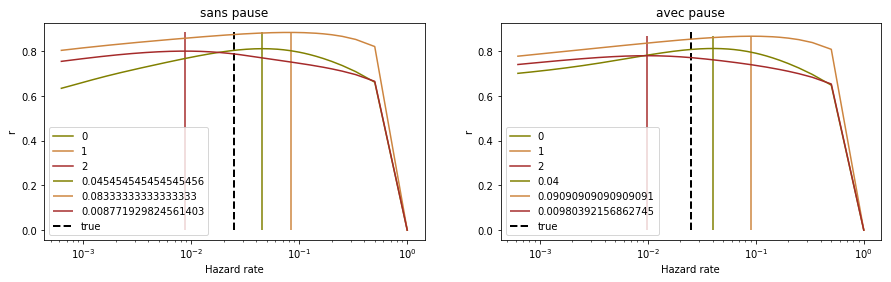

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))


for i_block in range(N_blocks):
    for i_mode, mode in enumerate(modes):
        ax[0].plot(hs, coco[i_mode, :, i_block], label=i_block, c=c[i_block])
        ax[0].vlines(hs[np.argmax(coco[i_mode, :, i_block])], ymin=np.nanmin(np.nanmean(coco, axis=(0))),
                     ymax=np.nanmax(np.nanmean(coco, axis=(0))), 
                     color=c[i_block], label=hs[np.argmax(coco[i_mode, :, i_block])])
        
        
        ax[1].plot(hs, coco_p[i_mode, :, i_block], label=i_block, c=c[i_block])
        ax[1].vlines(hs[np.argmax(coco_p[i_mode, :, i_block])], ymin=np.nanmin(np.nanmean(coco_p, axis=(0))),
                     ymax=np.nanmax(np.nanmean(coco_p, axis=(0))), 
                     color=c[i_block], label=hs[np.argmax(coco_p[i_mode, :, i_block])])

        
for a in range(2) :   
    ax[a].vlines(h, ymin=np.nanmin(np.nanmean(coco, axis=(0))), ymax=np.nanmax(np.nanmean(coco, axis=(0))), 
              linestyle='--', lw=2, label='true')

    ax[a].set_xscale("log")
    ax[a].set_xlabel('Hazard rate')
    ax[a].set_ylabel('r')
    ax[a].legend()
ax[0].set_title('sans pause')
ax[1].set_title('avec pause');